In [1]:
# Data Preprocessing
import os
import glob
import pandas as pd
# Feature Selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# Plots
import seaborn as sns
import matplotlib.pyplot as plt
# MLP
import torch
from torch.utils.data import Dataset, DataLoader

scaler = MinMaxScaler()
pd.set_option('display.float_format', '{:.2f}'.format)

# Data Preprocessing

## Calculate Export Value of Crop Products

Two export value datasets are created. One which maps countries yearly exports to individual crop products, and another which maps each country to the sum of its yearly crop products.

In [2]:
food_trade_indicators_df = pd.read_csv('Data/food_trade_indicators.csv')
print(food_trade_indicators_df['Item'].unique())
print()
print(food_trade_indicators_df.columns)

['Cereals and Preparations' 'Fats and Oils (excluding Butter)'
 'Meat and Meat Preparations' 'Sugar and Honey' 'Fruit and Vegetables'
 'Dairy Products and Eggs' 'Alcoholic Beverages' 'Non-alcoholic Beverages'
 'Other food' 'Non-food' 'Non-edible Fats and Oils' 'Tobacco']

Index(['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code',
       'Element', 'Item Code (CPC)', 'Item', 'Year Code', 'Year', 'Unit',
       'Value', 'Flag', 'Flag Description', 'Note'],
      dtype='object')


In [3]:
"""
Crop products

- Cereals and Preperations
    Edible grains fed to people and livestock
- Fats and Oils (exlcuding Butter)
    Fats and oils derived from plants such as rapeseed or olives
- Sugar and Honey
    80% of sugar comes from sugar cane, crops can be sowed specifically for bees to pollinate and produce honey
- Fruit and Vegetables
    Edible crops for human and animal consumption
- Alcoholic Beverages
    Crops such as potatoes and wheat/barley are used to make drinks like vodka and beer
- Non-alcoholic Beverages
    Crops such as lemons, oranges, apples and more are used to make juices
- Non-food
    Crops such as cotton and hemp are used to make textiles and clothing
- Tobacco
    Tobacco leaves are widely distributed around the world
"""
crop_products_dict = {
    'cereals': 'Cereals and Preparations',
    'fats': 'Fats and Oils (excluding Butter)',
    'sugar': 'Sugar and Honey',
    'fruit and veg': 'Fruit and Vegetables',
    'alcohol': 'Alcoholic Beverages',
    'drinks': 'Non-alcoholic Beverages',
    'materials': 'Non-food',
    'tobacco': 'Tobacco'
}

cols_to_drop = ['Domain Code', 'Domain', 'Element Code', 'Element', 'Item Code (CPC)', 'Year Code', 'Flag', 'Flag Description', 'Note']

food_trade_indicators_df = food_trade_indicators_df.drop(food_trade_indicators_df[food_trade_indicators_df['Element'] == 'Import Value'].index)
food_trade_indicators_df = food_trade_indicators_df.drop(food_trade_indicators_df[~food_trade_indicators_df['Item'].isin(list(crop_products_dict.values()))].index)
food_trade_indicators_df = food_trade_indicators_df.drop(columns=cols_to_drop)
food_trade_indicators_df = food_trade_indicators_df[food_trade_indicators_df['Year'] >= 2002]
food_trade_indicators_df.reset_index(drop=True, inplace=True)
display(food_trade_indicators_df)
food_trade_indicators_df.to_csv('Data/crop_export_values/yearly_crop_export_value_by_product.csv')

food_trade_indicators_df = food_trade_indicators_df.groupby(['Year', 'Area Code (M49)', 'Area', 'Unit'])['Value'].sum().reset_index()
display(food_trade_indicators_df)
food_trade_indicators_df.to_csv('Data/crop_export_values/yearly_crop_export_value.csv')

,Area Code (M49),Area,Item,Year,Unit,Value
0,4,Afghanistan,Cereals and Preparations,2009,1000 USD,15.00
1,4,Afghanistan,Cereals and Preparations,2010,1000 USD,54.00
2,4,Afghanistan,Cereals and Preparations,2011,1000 USD,0.00
3,4,Afghanistan,Cereals and Preparations,2012,1000 USD,0.00
4,4,Afghanistan,Cereals and Preparations,2013,1000 USD,0.00
...,...,...,...,...,...,...
30840,716,Zimbabwe,Tobacco,2018,1000 USD,893113.05
30841,716,Zimbabwe,Tobacco,2019,1000 USD,828488.44
30842,716,Zimbabwe,Tobacco,2020,1000 USD,794956.99
30843,716,Zimbabwe,Tobacco,2021,1000 USD,836533.69


,Year,Area Code (M49),Area,Unit,Value
0,2002,4,Afghanistan,1000 USD,34952.00
1,2002,8,Albania,1000 USD,28004.00
2,2002,12,Algeria,1000 USD,34132.00
3,2002,24,Angola,1000 USD,686.00
4,2002,28,Antigua and Barbuda,1000 USD,354.00
...,...,...,...,...,...
4071,2022,860,Uzbekistan,1000 USD,1851186.88
4072,2022,862,Venezuela (Bolivarian Republic of),1000 USD,147569.10
4073,2022,882,Samoa,1000 USD,10831.14
4074,2022,887,Yemen,1000 USD,148119.85


## Feature Selection

Each CSV file is a feature of the dataset. Some features have more dimensions than others, for example `consumer_prices` has two dimensions: `Consumer Prices, Food Indices (2015=100)`, a indication of the price levels of food since 2015, and `Food price inflation` which represents the rate of change of food prices over time. 

Linear relationships of these features to export crop yields can be determined by computing their correlation. Features with low linearity are thought to have little to no effect on the value of crop yields, however argriculture and its economics has complex relationships between all given features, implying there's importance to all. To explore this further, Random Forest regression can be used to evaluate non-linear feature importance. 

By combining linear (correlation) and non-linear (Random Forest regression) relationships between export crop yields and features, valuable inputs can be chosen for the model while minimising noise and keeping the parameter count as low as possible for faster training and convergence while requiring less computational expense.

In [4]:
exchange_rate_df = pd.read_csv('Data/raw_data/exchange_rate.csv')
exchange_rate_df_normalised = exchange_rate_df.groupby(['Year', 'Area Code (M49)', 'Area', 'Domain', 'Flag Description'])['Value'].mean().reset_index()

In [5]:
crop_yields_by_product_df = pd.read_csv('Data/crop_export_values/yearly_crop_export_value_by_product.csv', index_col=[0])
crop_yields_sum_products_df = pd.read_csv('Data/crop_export_values/yearly_crop_export_value.csv', index_col=[0])

In [6]:
def display_heatmap(correlation, title):
    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.title(f'{title}')
    plt.show()
    
def display_feature_importance(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'MSE: {mse}')

    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    display(feature_importance_df)
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Consumer Prices Feature Importance')
    plt.show()

### consumer_prices.csv

In [7]:
consumer_prices_df = pd.read_csv('Data/raw_data/consumer_prices.csv')
print(f"Units: {consumer_prices_df['Unit'].unique()}\n")
# Data is stored monthly. Change it to annually
consumer_prices_df = consumer_prices_df.groupby(['Year', 'Area', 'Item'])['Value'].mean().reset_index()
unique_items = consumer_prices_df['Item'].unique()
print(f'Unique items: {unique_items}')

Units: [nan '%']

Unique items: ['Consumer Prices, Food Indices (2015 = 100)' 'Food price inflation']


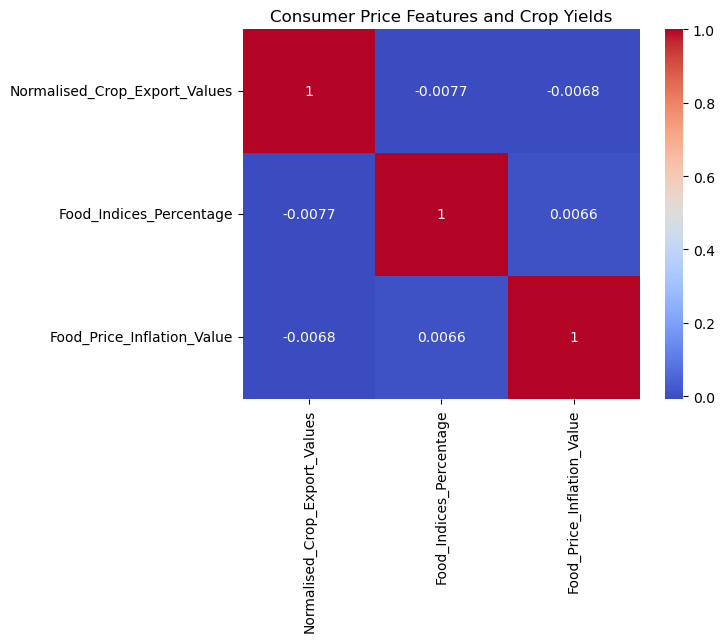

In [8]:
food_indices_df = consumer_prices_df[consumer_prices_df['Item'] == unique_items[0]]
food_indices_df = food_indices_df.rename(columns={'Value': 'Food_Indices_Value'})

food_price_infl_df = consumer_prices_df[consumer_prices_df['Item'] == unique_items[1]]
food_price_infl_df = food_price_infl_df.rename(columns={'Value': 'Food_Price_Inflation_Value'})

"""convert index values into percentages"""
# base year is 2015 (2015 = 100)
base_year = 2015
# get base year values
base_values = food_indices_df[food_indices_df['Year'] == base_year][['Area', 'Food_Indices_Value']].rename(columns={'Food_Indices_Value': 'Base_Year_Value'})
food_indices_df = pd.merge(food_indices_df, base_values, on='Area')
# calculate percentage change with respect to base year
food_indices_df['Food_Indices_Percentage'] = (food_indices_df['Food_Indices_Value'] / food_indices_df['Base_Year_Value'] - 1) * 100
food_indices_df = food_indices_df.drop(columns=['Food_Indices_Value', 'Base_Year_Value'])

merged_df_feature_1 = pd.merge(crop_yields_sum_products_df, food_indices_df[['Area', 'Year', 'Food_Indices_Percentage']], on=['Area', 'Year'])
merged_df_both_features = pd.merge(merged_df_feature_1, food_price_infl_df[['Area', 'Year', 'Food_Price_Inflation_Value']], on=['Area', 'Year'])
merged_df_both_features['Annual_Crop_Export_Values'] = crop_yields_sum_products_df['Value']
# Normalise annual crop yields to correlate better with percentages 
scaler = MinMaxScaler(feature_range=(0, 100))
merged_df_both_features['Normalised_Crop_Export_Values'] = scaler.fit_transform(merged_df_both_features[['Annual_Crop_Export_Values']])

correlation_export_crop_yield = merged_df_both_features[['Normalised_Crop_Export_Values', 'Food_Indices_Percentage', 'Food_Price_Inflation_Value']].corr()
display_heatmap(correlation_export_crop_yield, title='Consumer Price Features and Crop Yields')

MSE: 121337685644131.14


,Feature,Importance
1,Food_Price_Inflation_Value,0.51
0,Food_Indices_Percentage,0.49


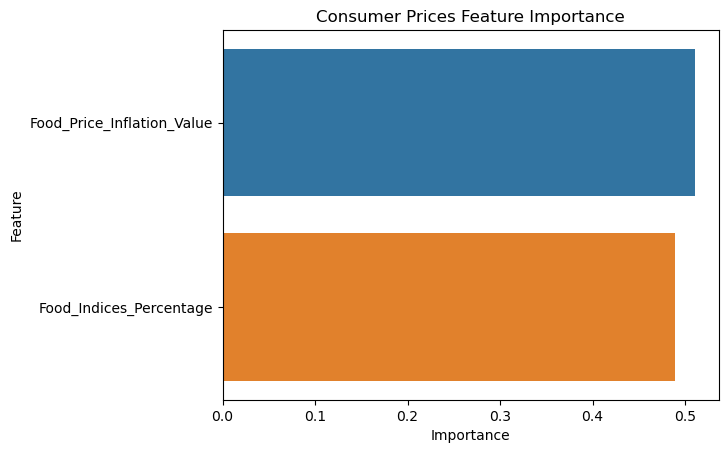

In [9]:
X = merged_df_both_features[['Food_Indices_Percentage', 'Food_Price_Inflation_Value']]
y = merged_df_both_features['Annual_Crop_Export_Values']

display_feature_importance(X, y)

### crops_production_indicators.csv


In [18]:
production_indicators_df = pd.read_csv('Data/raw_data/crops_production_indicators.csv')
unique_items = production_indicators_df['Item'].unique()
print(f"Units: {production_indicators_df['Unit'].unique()}\n")
print(f'Unique Items: {unique_items}')

Units: ['100 g/ha']

Unique Items: ['Cereals, primary' 'Citrus Fruit, Total' 'Fibre Crops, Fibre Equivalent'
 'Fruit Primary' 'Oilcrops, Cake Equivalent' 'Oilcrops, Oil Equivalent'
 'Pulses, Total' 'Roots and Tubers, Total' 'Sugar Crops Primary'
 'Treenuts, Total' 'Vegetables Primary']


In [19]:
# sort all production indicators by product and keep in their own dfs
cereals_df = production_indicators_df[production_indicators_df['Item'] == unique_items[0]].copy() # cereals and prep
citrus_df = production_indicators_df[production_indicators_df['Item'] == unique_items[1]].copy() # fruit and veg
materials_df = production_indicators_df[production_indicators_df['Item'] == unique_items[2]].copy() # non-food
fruit_df = production_indicators_df[production_indicators_df['Item'] == unique_items[3]].copy() # fruit and veg
oil_crops_cake_df = production_indicators_df[production_indicators_df['Item'] == unique_items[4]].copy() # fats and oils
oil_crops_oil_df = production_indicators_df[production_indicators_df['Item'] == unique_items[5]].copy() # fats and oils
pulses_df = production_indicators_df[production_indicators_df['Item'] == unique_items[6]].copy() # fruit and veg
sugars_df = production_indicators_df[production_indicators_df['Item'] == unique_items[7]].copy() # sugar and honey
roots_and_tubers_df = production_indicators_df[production_indicators_df['Item'] == unique_items[8]].copy() # fruit and veg
vegetables_df = production_indicators_df[production_indicators_df['Item'] == unique_items[10]].copy() # fruit and veg

In [20]:
# have all Item descriptions the same as crop export df
cereals_df.loc[:, 'Item'] = crop_products_dict['cereals']
materials_df.loc[:, 'Item'] = crop_products_dict['materials']
sugars_df.loc[:, 'Item'] = crop_products_dict['sugar']
oil_crops_cake_df.loc[:, 'Item'] = crop_products_dict['fats']
oil_crops_oil_df.loc[:, 'Item'] = crop_products_dict['fats']
citrus_df.loc[:, 'Item'] = crop_products_dict['fruit and veg']
fruit_df.loc[:, 'Item'] = crop_products_dict['fruit and veg']
pulses_df.loc[:, 'Item'] = crop_products_dict['fruit and veg']
roots_and_tubers_df.loc[:, 'Item'] = crop_products_dict['fruit and veg']
vegetables_df.loc[:, 'Item'] = crop_products_dict['fruit and veg']

fruit_and_veg_df = pd.concat([citrus_df, fruit_df, pulses_df, roots_and_tubers_df, vegetables_df])
fats_df = pd.concat([oil_crops_cake_df, oil_crops_oil_df])

fruit_and_veg_df = fruit_and_veg_df.groupby(['Area', 'Year', 'Item'], as_index=False)['Value'].sum()
fats_df = fats_df.groupby(['Area', 'Year', 'Item'], as_index=False)['Value'].sum()

In [21]:
# separate crop products into their own dfs
crop_yields_cereals_df = crop_yields_by_product_df[crop_yields_by_product_df['Item'] == crop_products_dict['cereals']]
crop_yields_fruit_and_veg_df = crop_yields_by_product_df[crop_yields_by_product_df['Item'] == crop_products_dict['fruit and veg']]
crop_yields_non_food_df = crop_yields_by_product_df[crop_yields_by_product_df['Item'] == crop_products_dict['materials']]
crop_yields_fats_df = crop_yields_by_product_df[crop_yields_by_product_df['Item'] == crop_products_dict['fats']]
crop_yields_sugar_df = crop_yields_by_product_df[crop_yields_by_product_df['Item'] == crop_products_dict['sugar']]


In [22]:
cereals_df = cereals_df.rename(columns={'Value': 'Cereals_Value'})
materials_df = materials_df.rename(columns={'Value': 'Materials_Value'})
sugars_df = sugars_df.rename(columns={'Value': 'Sugars_Value'})
fats_df = fats_df.rename(columns={'Value': 'Fats_Value'})
fruit_and_veg_df = fruit_and_veg_df.rename(columns={'Value': 'Fruit_And_Veg_Value'})

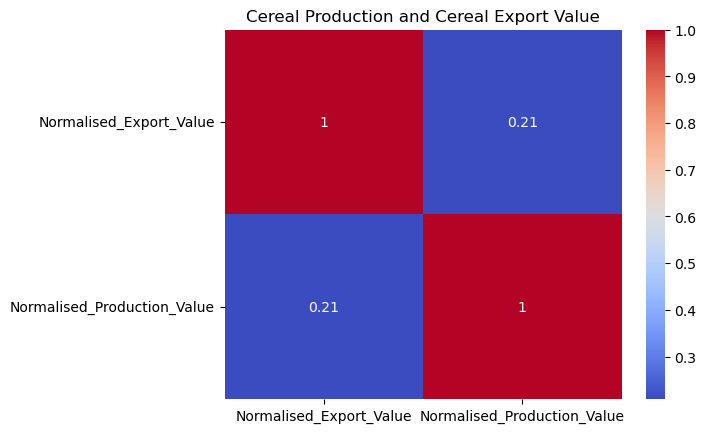

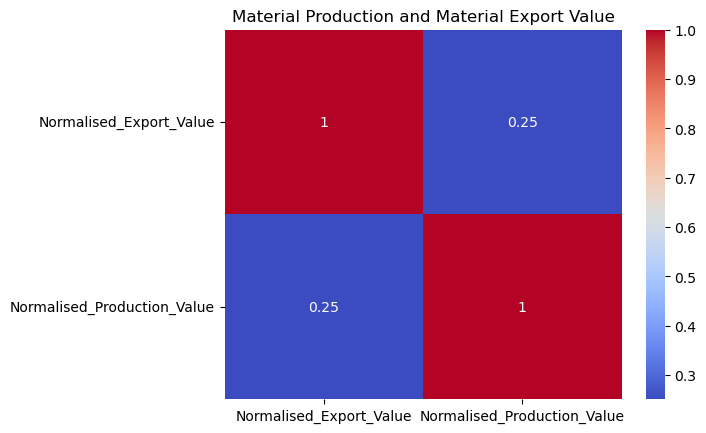

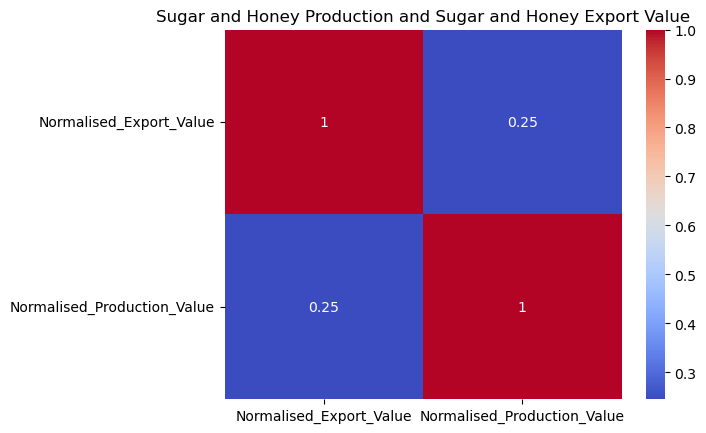

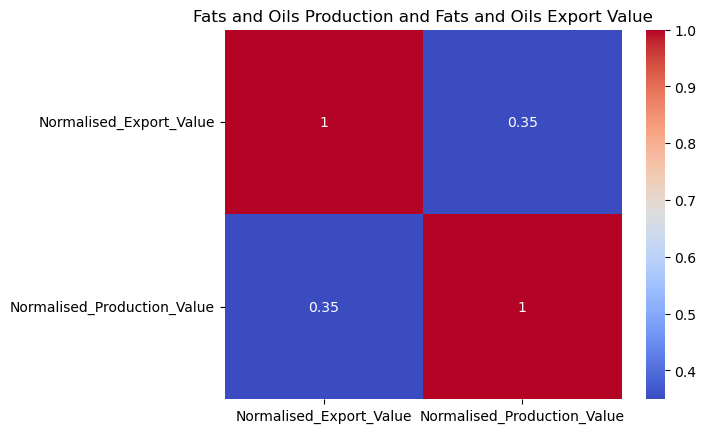

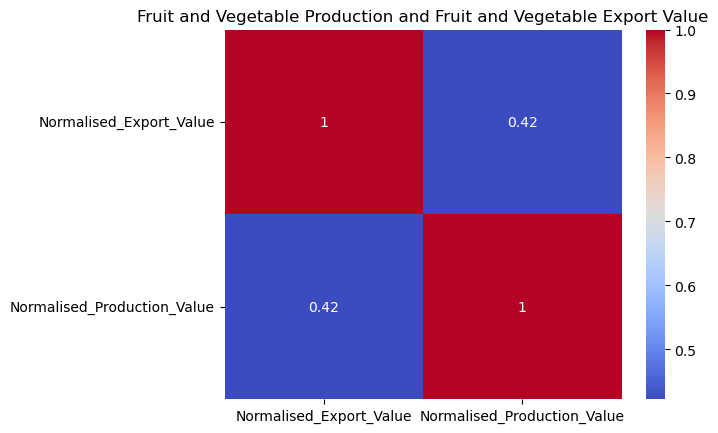

In [28]:
cereals_merged = pd.merge(cereals_df, crop_yields_cereals_df, on=['Area', 'Year'])
cereals_merged[['Normalised_Export_Value', 'Normalised_Production_Value']] = scaler.fit_transform(cereals_merged[['Value', 'Cereals_Value']])
cereals_correlation = cereals_merged[['Normalised_Export_Value', 'Normalised_Production_Value']].corr()
display_heatmap(cereals_correlation, 'Cereal Production and Cereal Export Value')

materials_merged = pd.merge(materials_df, crop_yields_non_food_df, on=['Area', 'Year'])
materials_merged[['Normalised_Export_Value', 'Normalised_Production_Value']]= scaler.fit_transform(materials_merged[['Value', 'Materials_Value']])
materials_correlation = materials_merged[['Normalised_Export_Value', 'Normalised_Production_Value']].corr()
display_heatmap(materials_correlation, 'Material Production and Material Export Value')

sugars_merged = pd.merge(sugars_df, crop_yields_sugar_df, on=['Area', 'Year'])
sugars_merged[['Normalised_Export_Value', 'Normalised_Production_Value']]= scaler.fit_transform(sugars_merged[['Value', 'Sugars_Value']])
sugars_correlation = sugars_merged[['Normalised_Export_Value', 'Normalised_Production_Value']].corr()
display_heatmap(sugars_correlation, 'Sugar and Honey Production and Sugar and Honey Export Value')

fats_merged = pd.merge(fats_df, crop_yields_fats_df, on=['Area', 'Year'])
fats_merged[['Normalised_Export_Value', 'Normalised_Production_Value']]= scaler.fit_transform(fats_merged[['Value', 'Fats_Value']])
fats_correlation = fats_merged[['Normalised_Export_Value', 'Normalised_Production_Value']].corr()
display_heatmap(fats_correlation, 'Fats and Oils Production and Fats and Oils Export Value')

fruit_and_veg_merged = pd.merge(fruit_and_veg_df, crop_yields_fruit_and_veg_df, on=['Area', 'Year'])
fruit_and_veg_merged[['Normalised_Export_Value', 'Normalised_Production_Value']]= scaler.fit_transform(fruit_and_veg_merged[['Value', 'Fruit_And_Veg_Value']])
fruit_and_veg_correlation = fruit_and_veg_merged[['Normalised_Export_Value', 'Normalised_Production_Value']].corr()
display_heatmap(fruit_and_veg_correlation, 'Fruit and Vegetable Production and Fruit and Vegetable Export Value')

/var/folders/r7/pmx4mq9n359ff5rbmwjtfsqh0000gn/T/ipykernel_45769/2536892349.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Item_x'} in the result is deprecated and will raise a MergeError in a future version.
  all_merged = pd.merge(all_merged, fats_df, on=['Area', 'Year'])


MSE: 88552970262197.12


,Feature,Importance
4,Fruit_And_Veg_Value,0.22
0,Cereals_Value,0.22
3,Fats_Value,0.20
2,Sugars_Value,0.19
1,Materials_Value,0.17


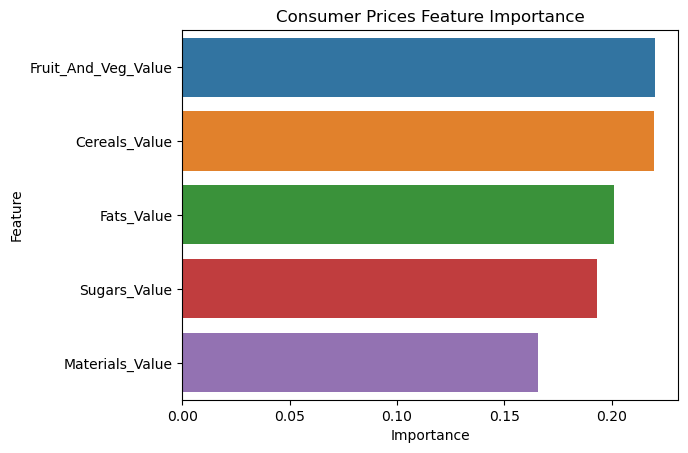

In [37]:
all_merged = pd.merge(cereals_df, materials_df, on=['Area', 'Year'])
all_merged = pd.merge(all_merged, sugars_df, on=['Area', 'Year'])
all_merged = pd.merge(all_merged, fats_df, on=['Area', 'Year'])
all_merged = pd.merge(all_merged, fruit_and_veg_df, on=['Area', 'Year'])
all_merged['Annual_Crop_Export_Values'] = crop_yields_sum_products_df['Value']
X = all_merged[['Cereals_Value', 'Materials_Value', 'Sugars_Value', 'Fats_Value', 'Fruit_And_Veg_Value']]
y = all_merged['Annual_Crop_Export_Values']

display_feature_importance(X, y)

### emissions.csv

In [ ]:
production_indicators_df = pd.read_csv('Data/raw_data/crops_production_indicators.csv')
unique_items = production_indicators_df['Item'].unique()
print(f"Units: {production_indicators_df['Unit'].unique()}\n")
print(f'Unique Items: {unique_items}')

In [ ]:
# faostat_data = glob.glob(os.path.join('Data/raw_data/', '*.csv'))

# # Inspect csv files before selecting features
# for file_name in faostat_data:
#     df = pd.read_csv(file_name)
#     print(file_name.strip('Data/raw_data/'))
#     # display(df) # output hidden after inspection for brevity

# drop_cols = ['Element Code', 'Months', 'Months Code', 'Flag','Note', 'Source', 
#              'Source Code', 'Item Code', 'Item Code (CPC)', 'Year Code', 
#              'ISO Currency Code (FAO)', 'Domain Code','Element', 'Sex', 
#              'Sex Code', 'Indicator', 'Item Code (FBS)', 'Item', 'Indicator Code']

# for file_name in faostat_data:
#     df = pd.read_csv(file_name)
#     cols_to_drop = [col for col in drop_cols if col in df.columns]
#     df = df.drop(columns=cols_to_drop)
    
#     if 'Year' in df.columns:
#         # food_security_indicators.csv has dates in form '2000-2002' 
#         df['Year'] = df['Year'].astype(str)
#         if df['Year'].str.contains('-').any():
#             # keep only the first part of the year
#             df['Year'] = df['Year'].apply(lambda x: int(x.split('-')[0]))
#         # convert from string to integer
#         df['Year'] = df['Year'].astype(int)
#         # only keep years >= 2002 as all files have data from this year
#         df = df[df['Year'] >= 2002]
        
#     file_name = os.path.join('Data/feature_selected/', os.path.basename(file_name))
#     df.to_csv(file_name, index=False)
#     print(file_name.strip('Data/raw_data/'))
#     # display(df) # output hidden after inspection for brevity

feature_selected/land_temperature_change.csv
feature_selected/consumer_prices.csv
feature_selected/crops_production_indicators.csv
feature_selected/foreign_direct_investment.csv
feature_selected/exchange_rate.csv
feature_selected/emissions.csv
feature_selected/food_balance_indicators.csv
feature_selected/pesticide_use.csv


/var/folders/r7/pmx4mq9n359ff5rbmwjtfsqh0000gn/T/ipykernel_81320/4292690173.py:7: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


feature_selected/land_use.csv
feature_selected/employment_data.csv
feature_selected/food_security_indicators.csv
feature_selected/fertilizers.csv


## Handle NaN values

Identify which features have NaN values and handle them by finding the average from the year before and the year after the missing value. If both of those values are missing, use whichever is not NaN.

`land_temperature_change.csv` was altered as the `Value` column had missing values.

`consumer_prices.csv` and `exchange_rate.csv` are unchanged as the `NaN` values are in the `Unit` column which is not going to fed to the model.


In [ ]:
# Check if feature selected data has NaN values
faostat_data = glob.glob(os.path.join('Data/feature_selected/', '*.csv'))

for file_name in faostat_data:
    df = pd.read_csv(file_name)
    if df.isnull().values.any():
        print(f'{file_name} contains NaN values')
        nan_cols = [(c, df[c].hasnans) for c in df]
        print(nan_cols)
        print()

Data/feature_selected/land_temperature_change.csv contains NaN values
[('Domain', False), ('Area Code (M49)', False), ('Area', False), ('Year', False), ('Unit', False), ('Value', True), ('Flag Description', False)]

Data/feature_selected/consumer_prices.csv contains NaN values
[('Domain', False), ('Area Code (M49)', False), ('Area', False), ('Year', False), ('Unit', True), ('Value', False), ('Flag Description', False)]

Data/feature_selected/exchange_rate.csv contains NaN values
[('Domain', False), ('Area Code (M49)', False), ('Area', False), ('Currency', False), ('Year', False), ('Unit', True), ('Value', False), ('Flag Description', False)]



In [ ]:
# Handle NaN values in land_temperate_change.csv Value column
land_temp_df = pd.read_csv('Data/feature_selected/land_temperature_change.csv')
    
for i in range(len(land_temp_df)):
    if 'Missing' in land_temp_df.loc[i, 'Flag Description']:
        if i > 0 and i < len(land_temp_df) - 1:
            year_before = land_temp_df.loc[i - 1, 'Value']
            year_after = land_temp_df.loc[i + 1, 'Value']
            # if values on both sides are available use an average
            if pd.notna(year_before) and pd.notna(year_after):
                land_temp_df.loc[i, 'Value'] = (year_before + year_after) / 2
            # otherwise use the year before
            elif pd.notna(year_before):
                land_temp_df.loc[i, 'Value'] = year_before
            # otherwise use the year after
            elif pd.notna(year_after):
                land_temp_df.loc[i, 'Value'] = year_after

if land_temp_df.isnull().any().any():
    print(f'{file_name} contains NaN values')
else:
    # no more NaN values so overwrite file
    land_temp_df.to_csv('Data/feature_selected/land_temperature_change.csv')

## Normalise Data



`exchange_rate.csv` and `consumer_prices.csv` store data monthly rather than yearly like the other feature sets. For each year in each country the monthly data is summed and averaged. The original features are then overwritten. This standardises the data so all features now have yearly values.

In [ ]:
exchange_rate_df = pd.read_csv('Data/raw_data/exchange_rate.csv')
exchange_rate_df_normalised = exchange_rate_df.groupby(['Year', 'Area Code (M49)', 'Area', 'Domain', 'Flag Description'])['Value'].mean().reset_index()
exchange_rate_df_normalised.to_csv('Data/feature_selected/exchange_rate.csv')

consumer_prices_df = pd.read_csv('Data/raw_data/consumer_prices.csv')
consumer_prices_df_normalised = consumer_prices_df.groupby(['Year', 'Area Code (M49)', 'Area', 'Domain', 'Flag Description'])['Value'].mean().reset_index()
consumer_prices_df_normalised.to_csv('Data/feature_selected/consumer_prices.csv')

# Create Dataset and DataLoaders

In [ ]:
class CropForecastDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)